In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sweetviz as sv

from scipy.stats import ttest_ind, zscore
from summarytools import dfSummary

# Load Engineered data

In [2]:
malicious_features = pd.read_pickle("data/malicious_features_numeric.pkl")
benign_features = pd.read_pickle("data/benign_features_numeric.pkl")

In [3]:
malicious_features

,Timestamp,Source Port,Destination Port,Payload,Packet Length,Protocol,src_ip_total_bytes,dst_ip_total_bytes,Numeric Source IP,Numeric Destination IP,dst_port_freq_encoded,Interarrival
0,1.540446e+09,21074.0,80.0,Padding,26,6.0,26,26,3232236140,873999171,0.114505,NaN
1,1.540446e+09,20532.0,8280.0,Padding,26,6.0,52,26,3232236140,874070778,0.040794,0.000005
7,1.540446e+09,2440.0,53.0,"DNS Qry ""b'xmpp.samsungsmartcam.com.Speedport_...",83,17.0,83,83,3232236147,3232236033,0.216419,0.457747
8,1.540446e+09,53.0,2440.0,DNS Ans,83,17.0,83,83,3232236033,3232236147,0.000013,0.002058
9,1.540446e+09,21074.0,80.0,Padding,26,6.0,78,52,3232236140,873999171,0.114505,0.042112
...,...,...,...,...,...,...,...,...,...,...,...,...
764121,1.540454e+09,32761.0,10240.0,Raw,48,17.0,2207242,633840,3232236140,1035740632,0.406152,0.000002
764122,1.540454e+09,35284.0,53.0,"DNS Qry ""b'time.windows.com.'""",42,17.0,241142,158024,3232236141,134744072,0.216419,0.153157
764124,1.540454e+09,47157.0,80.0,Padding,26,6.0,2207268,163490,3232236140,873999171,0.114505,0.301136
764125,1.540454e+09,46453.0,8280.0,Padding,26,6.0,2207294,163436,3232236140,874070778,0.040794,0.000078


In [4]:
benign_features

,Timestamp,Source Port,Destination Port,Payload,Packet Length,Protocol,src_ip_total_bytes,dst_ip_total_bytes,Numeric Source IP,Numeric Destination IP,dst_port_freq_encoded,Interarrival
4,1.355254e+09,646.0,646.0,Raw,42,17.0,42,42,167772161,3758096386,0.017728,NaN
5,1.355254e+09,646.0,646.0,Raw,42,17.0,84,84,167772161,3758096386,0.017728,0.000000
6,1.355254e+09,646.0,646.0,Raw,42,17.0,42,126,167772162,3758096386,0.017728,0.187000
7,1.355254e+09,646.0,646.0,Raw,42,17.0,84,168,167772162,3758096386,0.017728,0.000000
26,1.355254e+09,646.0,646.0,Raw,42,17.0,126,210,167772162,3758096386,0.017728,4.087000
...,...,...,...,...,...,...,...,...,...,...,...,...
38585,1.671036e+09,1812.0,10048.0,Radius,40,17.0,264,4648,3270968603,3270968577,0.000054,0.000360
38586,1.671036e+09,3860.0,1812.0,Radius,112,17.0,91433,575,3270968577,3270968603,0.000376,10.522429
38587,1.671036e+09,1812.0,3860.0,Radius,104,17.0,368,4752,3270968603,3270968577,0.000054,0.000545
38588,1.671036e+09,3373.0,1812.0,Radius,120,17.0,91553,695,3270968577,3270968603,0.000376,12.588217


In [5]:
malicious_features.pop("Payload")
benign_features.pop("Payload")

4           Raw
5           Raw
6           Raw
7           Raw
26          Raw
          ...  
38585    Radius
38586    Radius
38587    Radius
38588    Radius
38589    Radius
Name: Payload, Length: 18615, dtype: object

# EDA

Exploratory Data Analysis approaches the dataset as a black box that we need to visualize and analyze statistically with the following goals:
- get insights about our data
- test hypotheses
- decide on models and further processing, such as feature engineering.

EDA can be performed for benign and malicious data. Here we are looking at EDA only for malicious data, however the same functions can be applied to benign.

## Descriptive statistics & data

- Describe columns and data types
- Descriptive statistics
  -  count, 
  -  mean, 
  -  standard deviation, 
  -  minimum, 
  -  25th percentile, 
  -  median (50th percentile), 
  -  75th percentile, and 
  -  maximum

In [6]:
malicious_features.describe()

,Timestamp,Source Port,Destination Port,Packet Length,Protocol,src_ip_total_bytes,dst_ip_total_bytes,Numeric Source IP,Numeric Destination IP,dst_port_freq_encoded,Interarrival
count,1.540900e+05,154090.000000,154090.000000,154090.000000,154090.000000,1.540900e+05,1.540900e+05,1.540900e+05,1.540900e+05,154090.000000,154089.000000
mean,1.540450e+09,31461.554105,6758.415673,45.299890,13.348420,6.480438e+05,2.883691e+05,3.231670e+09,1.970533e+09,0.233578,0.046317
std,2.080248e+03,18801.836599,7691.364297,17.558657,5.180108,5.928930e+05,3.112853e+05,4.278200e+07,1.039605e+09,0.156511,0.091788
min,1.540446e+09,0.000000,23.000000,20.000000,6.000000,2.600000e+01,2.600000e+01,0.000000e+00,1.347441e+08,0.000006,-0.000269
25%,1.540448e+09,21897.000000,53.000000,40.000000,6.000000,1.617865e+05,6.316800e+04,3.232236e+09,8.740708e+08,0.061432,0.000061
50%,1.540450e+09,32761.000000,8280.000000,48.000000,17.000000,4.427145e+05,1.624365e+05,3.232236e+09,2.014854e+09,0.216419,0.001171
75%,1.540452e+09,50861.000000,10240.000000,48.000000,17.000000,1.050067e+06,4.276460e+05,3.232236e+09,3.232236e+09,0.406152,0.051200
max,1.540454e+09,65267.000000,65267.000000,166.000000,17.000000,2.207294e+06,1.423395e+06,3.232236e+09,4.294967e+09,0.406152,1.176720


In [7]:
benign_features.describe()

,Timestamp,Source Port,Destination Port,Packet Length,Protocol,src_ip_total_bytes,dst_ip_total_bytes,Numeric Source IP,Numeric Destination IP,dst_port_freq_encoded,Interarrival
count,1.861500e+04,18615.000000,18615.000000,18615.000000,18615.000000,1.861500e+04,1.861500e+04,1.861500e+04,1.861500e+04,18615.000000,1.861400e+04
mean,1.561492e+09,26100.062208,12621.709911,297.704110,15.524899,4.799977e+05,4.657947e+05,2.673749e+09,2.754457e+09,0.078901,1.696476e+04
std,5.667702e+07,24859.356286,17691.465555,447.200549,6.462379,8.002136e+05,7.824794e+05,1.059710e+09,1.059214e+09,0.075002,5.601252e+05
min,1.355254e+09,7.000000,7.000000,9.000000,6.000000,2.000000e+01,2.000000e+01,0.000000e+00,1.684301e+07,0.000054,-9.703636e-05
25%,1.509911e+09,5690.000000,1303.000000,56.000000,17.000000,5.966000e+03,6.962000e+03,1.418889e+09,1.418889e+09,0.009079,3.480911e-05
50%,1.574093e+09,15020.000000,5690.000000,180.000000,17.000000,1.169920e+05,1.022400e+05,3.232237e+09,3.232237e+09,0.049530,4.282355e-03
75%,1.597832e+09,54505.500000,15020.000000,180.000000,17.000000,4.722740e+05,4.641315e+05,3.239633e+09,3.628225e+09,0.172710,1.757365e-02
max,1.671036e+09,65535.000000,65535.000000,8780.000000,47.000000,2.760212e+06,2.732799e+06,3.640661e+09,4.294967e+09,0.180929,3.504942e+07


In [8]:
mirai_correlation_matrix = malicious_features.corr()
mirai_correlation_matrix

,Timestamp,Source Port,Destination Port,Packet Length,Protocol,src_ip_total_bytes,dst_ip_total_bytes,Numeric Source IP,Numeric Destination IP,dst_port_freq_encoded,Interarrival
Timestamp,1.000000,-0.128160,0.069707,-0.131946,-0.177842,0.518957,0.455726,0.011192,0.153173,-0.148588,-0.063879
Source Port,-0.128160,1.000000,-0.060443,-0.165664,0.031855,0.142800,-0.165874,0.022104,-0.500735,0.332926,-0.058298
Destination Port,0.069707,-0.060443,1.000000,-0.027235,0.019889,0.114645,-0.206290,0.011517,-0.130771,0.152054,-0.243491
Packet Length,-0.131946,-0.165664,-0.027235,1.000000,0.545078,-0.044515,0.149489,-0.091002,0.221897,0.148888,0.026269
Protocol,-0.177842,0.031855,0.019889,0.545078,1.000000,0.107061,0.308723,-0.009332,0.005004,0.757495,0.061819
src_ip_total_bytes,0.518957,0.142800,0.114645,-0.044515,0.107061,1.000000,0.204632,0.014418,-0.391377,0.383237,-0.122832
dst_ip_total_bytes,0.455726,-0.165874,-0.206290,0.149489,0.308723,0.204632,1.000000,0.011855,0.262773,0.136437,0.157076
Numeric Source IP,0.011192,0.022104,0.011517,-0.091002,-0.009332,0.014418,0.011855,1.000000,-0.029600,0.019742,-0.004191
Numeric Destination IP,0.153173,-0.500735,-0.130771,0.221897,0.005004,-0.391377,0.262773,-0.029600,1.000000,-0.340534,0.040813
dst_port_freq_encoded,-0.148588,0.332926,0.152054,0.148888,0.757495,0.383237,0.136437,0.019742,-0.340534,1.000000,-0.067594


In [9]:
benign_correlation_matrix = benign_features.corr()
benign_correlation_matrix

,Timestamp,Source Port,Destination Port,Packet Length,Protocol,src_ip_total_bytes,dst_ip_total_bytes,Numeric Source IP,Numeric Destination IP,dst_port_freq_encoded,Interarrival
Timestamp,1.000000,-0.238044,0.175399,-0.175670,-0.137366,-0.385764,-0.376098,0.027331,-0.180346,-0.257925,-0.020904
Source Port,-0.238044,1.000000,-0.364698,0.385247,-0.001969,0.547512,0.574038,0.340619,-0.041412,0.384128,-0.000208
Destination Port,0.175399,-0.364698,1.000000,-0.105459,-0.178826,-0.281545,-0.281247,-0.343660,0.008705,-0.407315,-0.017173
Packet Length,-0.175670,0.385247,-0.105459,1.000000,-0.020476,0.237230,0.243572,0.058364,0.110793,0.303754,-0.012279
Protocol,-0.137366,-0.001969,-0.178826,-0.020476,1.000000,0.088461,0.082099,0.108441,0.123732,0.215613,0.002431
src_ip_total_bytes,-0.385764,0.547512,-0.281545,0.237230,0.088461,1.000000,0.960583,0.217656,0.189778,0.530767,-0.018029
dst_ip_total_bytes,-0.376098,0.574038,-0.281247,0.243572,0.082099,0.960583,1.000000,0.218065,0.178040,0.556927,-0.017907
Numeric Source IP,0.027331,0.340619,-0.343660,0.058364,0.108441,0.217656,0.218065,1.000000,-0.166954,0.439716,0.003683
Numeric Destination IP,-0.180346,-0.041412,0.008705,0.110793,0.123732,0.189778,0.178040,-0.166954,1.000000,-0.197721,0.002715
dst_port_freq_encoded,-0.257925,0.384128,-0.407315,0.303754,0.215613,0.530767,0.556927,0.439716,-0.197721,1.000000,-0.025356


In [10]:
# Create a heatmap
def correlation_heatmap(correlation_matrix):
    plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
    sns.set(font_scale=1.2)  # Adjust the font size as needed

    # Customize the heatmap
    sns.heatmap(
        correlation_matrix,
        annot=True,
        cmap="coolwarm",
        square=True,
        xticklabels=[
            "Timestamp",
            "Source Port",
            "Destination Port",
            "Packet Length",
            "Protocol",
            "src_ip_total_bytes",
            "dst_ip_total_bytes",
            "Number of Packets",
            "Source IP numeric",
            "Destination IP numeric",
            "dst_port_freq_encoded",
            "Interarrival",
        ],
        yticklabels=[
            "Timestamp",
            "Source Port",
            "Destination Port",
            "Packet Length",
            "Protocol",
            "src_ip_total_bytes",
            "dst_ip_total_bytes",
            "Number of Packets",
            "Source IP numeric",
            "Destination IP numeric",
            "dst_port_freq_encoded",
            "Interarrival",
        ],
    )

    plt.title("Correlation Heatmap")
    plt.show()

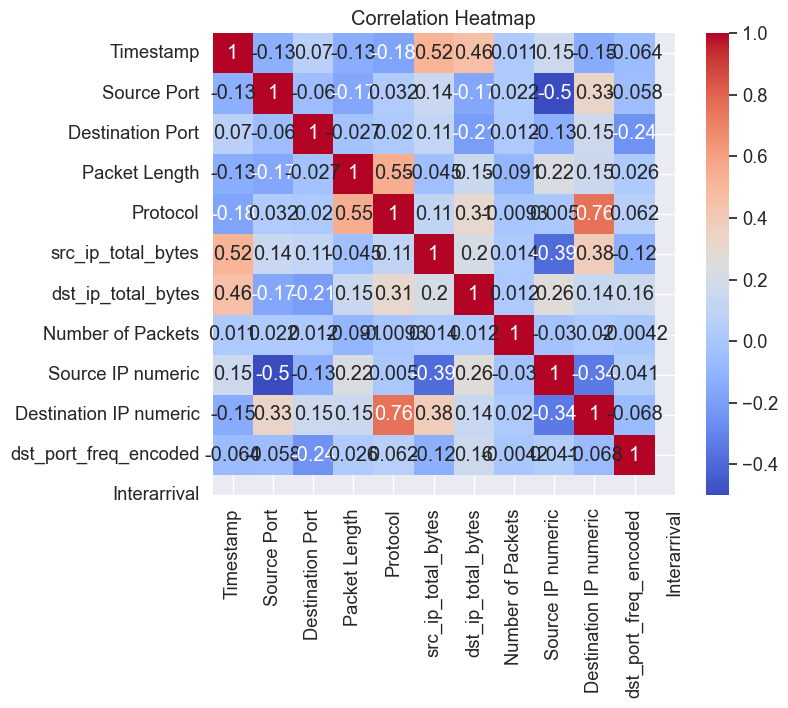

In [11]:
correlation_heatmap(mirai_correlation_matrix)

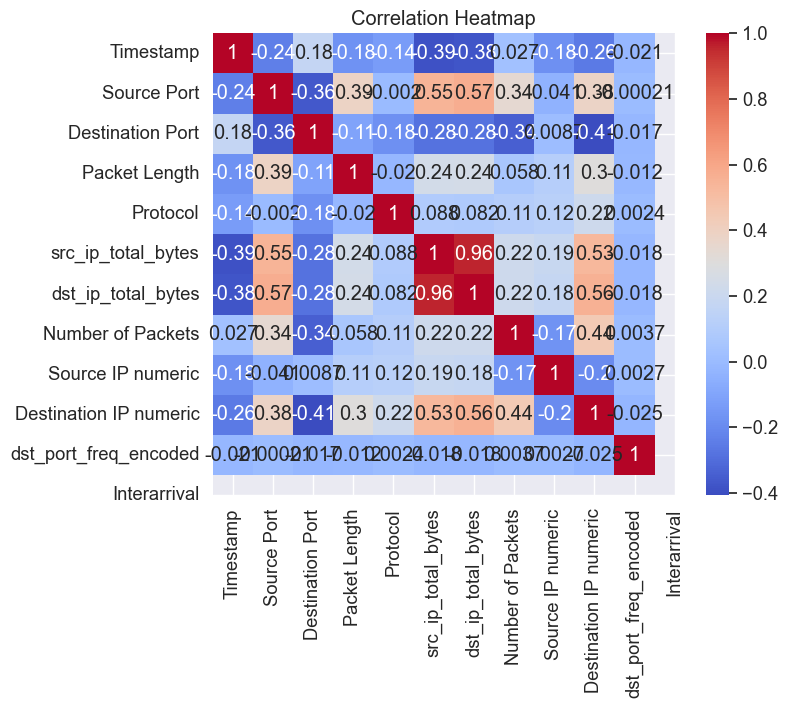

In [12]:
correlation_heatmap(benign_correlation_matrix)

## Hypothesis testing

- Is the difference between two groups or variables statistically significant?
- Use t-test to compare means of two groups
  - assumes that data follows normal distribution
- Types of variables
  - dependent: the effect of a phenomenon. For example, how does number of HTTP requests mean that a network is compromised?
  - independent: the cause. The number of HTTP requests affects whether a network is compromised.

In [13]:
def hypothesis_testing(df, col1, col2):
    group1 = df[col1]
    group2 = df[col2]
    pvalue = ttest_ind(group1, group2)[1]
    if pvalue < 0.05:
        return "The difference between {} and {} is statistically significant (p < 0.05)".format(
            col1, col2
        )
    else:
        return "The difference between {} and {} is not statistically significant (p >= 0.05)".format(
            col1, col2
        )

In [14]:
hypothesis_testing(malicious_features, "dst_port_freq_encoded", "Packet Length")

'The difference between dst_port_freq_encoded and Packet Length is statistically significant (p < 0.05)'

In [15]:
hypothesis_testing(benign_features, "dst_port_freq_encoded", "Packet Length")

'The difference between dst_port_freq_encoded and Packet Length is statistically significant (p < 0.05)'

## Outliers

- observation that significantly differs from others in a dataset
- Causes
  - measurement errors
  - extreme rare values
- significant impact in statistical analysis
- measurements
  - z-score: `(x - mean) / std_dev`
  - IQR method: this method identifies outliers as observations that are below `Q1 - 1.5IQR` or above `Q3 + 1.5IQR`, where Q1 and Q3 are the first and third quartiles, and IQR is the interquartile range (the difference between Q3 and Q1).
  - visual inspection

In [16]:
def detect_outliers_zscore(df, column, threshold=3):
    zscores = np.abs(zscore(df[column]))
    return df[zscores > threshold]

In [17]:
outliers = detect_outliers_zscore(malicious_features, "Packet Length", threshold=3)
print(outliers)

           Timestamp  Source Port  Destination Port  Packet Length  Protocol  \
89      1.540446e+09      43537.0            1900.0            145      17.0   
581     1.540446e+09       1215.0            1900.0            166      17.0   
582     1.540446e+09       1215.0            1900.0            166      17.0   
583     1.540446e+09       1215.0            1900.0            166      17.0   
1012    1.540446e+09         67.0              68.0            166      17.0   
...              ...          ...               ...            ...       ...   
754911  1.540453e+09       1215.0            1900.0            166      17.0   
762373  1.540454e+09       1215.0            1900.0            166      17.0   
762374  1.540454e+09       1215.0            1900.0            166      17.0   
762375  1.540454e+09       1215.0            1900.0            166      17.0   
763551  1.540454e+09         67.0              68.0            166      17.0   

        src_ip_total_bytes  dst_ip_tota

In [18]:
outliers = detect_outliers_zscore(benign_features, "Packet Length", threshold=3)
print(outliers)

          Timestamp  Source Port  Destination Port  Packet Length  Protocol  \
1993   1.460283e+09        443.0           50477.0           2928       6.0   
2062   1.460283e+09      45271.0              25.0           7272       6.0   
2063   1.460283e+09      45271.0              25.0           3097       6.0   
14426  1.560870e+09         53.0           39005.0           1764       6.0   
23800  1.589384e+09      11371.0           39638.0           4272       6.0   
23801  1.589384e+09      11371.0           39638.0           4116       6.0   
23802  1.589384e+09      11371.0           39638.0           3859       6.0   
23887  1.597832e+09      65439.0            9100.0           8780       6.0   
23893  1.597832e+09      65439.0            9100.0           2940       6.0   
23895  1.597832e+09      65439.0            9100.0           4400       6.0   
23897  1.597832e+09      65439.0            9100.0           4400       6.0   
23899  1.597832e+09      65439.0            9100.0  

In [19]:
# TODO: plot outliers
# plt.figure(figsize=(8, 6))  # Adjust the figure size as needed

# # Create a box plot with regular values
# sns.boxplot(data=benign_stream_df, x='Duration', y='Total Length', color='lightblue', label='Regular Values')

# # Overlay the outlier points on the same plot
# sns.scatterplot(data=outliers, x='Duration', y='Total Length', color='red', marker='X', label='Outliers')

# plt.title('Box Plot with Outliers')
# plt.xlabel('Duration')
# plt.ylabel('Total Length')
# plt.legend()
# plt.show()

# Summaries & Visualizations
Using packages `dfSummary` and `sweetviz`, we create a wealth of visualizations with minimal code. These visualizations offer valuable insights for data exploration.

In [20]:
dfSummary(malicious_features)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Timestamp[float64],Mean (sd) : 1540450214.8 (2080.2)min < med < max:1540446382.9 < 1540450432.6 < 1540453519.8IQR (CV) : 3618.0 (740512.8),"154,090 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJwAAAA4CAYAAAAINZG1AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAB8klEQVR4nO3cQW7aQBiG4X/cgkxAHiFUOECW3bHkED1sj9AFJ2DRTVfskJBlhBsrYLurSlHUEjIWnzv0fZZIX+RIr2IlM4pr29YAlY99PwCu55wbmdkwYJqYWSPcmZk9t2379PpDgouEc240m82+ZFk2fc+urutBWZaPk8nkR5Ikp1vvfjscDrlz7uvr6AguHsMsy6ar1erJe19dO9put9PNZvNpuVx+XywW+a13ZmZFUaTr9Xq63++HZkZwfQt8NWZN0wy89/l8Pv957SjP85GZ2Xg8rhS7F0Z/+pDgxEJfjafTKa3r+nNVVd/MLCSAfwLB6XV5NT6cz+cPt3y4WyO4nnjvg15xsUv6fgD8XwgOUgQHKYKDFMFBiuAgRXCQuvh3uB5uJ3TZxrLLmqYZBOzuwl+DU99O6LKNZWd2P0dUoS79hJPeTuiyjWX3Yhv9EVWoN4+2Qo9gQm4ZqG829HGT4l6OqELxSwOkCA5SBAcpgoMUwUGK4CBFcJAiOEgRHKQIDlIEBymCgxTBQYrgIEVwkCI4SBEcpAgOUgQHKYKDFMFBiuAgRXCQIjhIERykCA5SBAcpgoMUwUGK4CBFcJAiOEgRHKQIDlIEBymCg9Sb/1S6KIr0PV/weDymZmZlWaa73e5BsY1lF9OzdvkeLzXzC+ptS+H2FLriAAAAAElFTkSuQmCC"">",0(0.0%)
2,Source Port[float64],Mean (sd) : 31461.6 (18801.8)min < med < max:0.0 < 32761.0 < 65267.0IQR (CV) : 28964.0 (1.7),"22,952 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJwAAAA4CAYAAAAINZG1AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACeklEQVR4nO3dPY7aQBjG8WdgQYNBthEKdDQpXERKQckhctgcIQUnoKWI6Cw+ZISzjo1xLhBYPMYv6/Hz60f2yv/Z1b47ZlVRFCCS8vbqG2gqpdQAQN9weVoUxfsz76cpGJwBpdRgMpn8cF13bLL+dDodlVI/2xgdgzPTd113vFwu3z3PS8osjKJIr1ar8X6/7wNgcPQ4z/OS6XT6x2Dp4Ok30xCdV98AtQuDI1EMjkQxOBLF4EgUgyNRDI5EMTgSxeBIFIMjUQyORDE4EnX3j/cVzny19rxXnWx4HjeDq3Lmq83nvepiy/O49x3O6MxX28971ciK5/HheTjDM1+tPe9Vt6Y/D/7SQKIYHIlicCSKwZEoBkeiGByJYnAkisGRKAZHohgciWJwJIrBkSgGR6IYHIlicCSKwZEoBkeiGByJYnAkisGRKAZHohgcibLmY/NteCu9DawIzpa30uuS53kPgKuUKrv06ZvRiuDQsLfSDQNwr9drr+y14jjuZVn2fT6fd7vdbqn/mlPHZrQlOADNeCvdNIAsy3Se59+SJPkF4OGvMU3TN621s1gsktlsdnx0XV2b0argmsA0gO12O16v187lcumaXHc4HH6KzcjgXqRsAMfj8dN8PkgVHIuQKAZHovgjlW6qME4BboxUGBz9V5VxCnB7pFJLcBV3RgfAteQaoxkVIDsTaxLT36aB+yOVpwdXZWfked6L4/jraDTadDqd7NF1pjMq6ZlYExmOU4AbI5UPg4uiSJe5yuFwGGmtnSAIlO/7f8us3e12erPZfAmC4Lfv++eS65woioZhGKZ136vp9QDgfD5rAIjjWIdh6Ni2DrjfzD+jmX5UDQDXmAAAAABJRU5ErkJggg=="">",0(0.0%)
3,Destination Port[float64],Mean (sd) : 6758.4 (7691.4)min < med < max:23.0 < 8280.0 < 65267.0IQR (CV) : 10187.0 (0.9),"3,691 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJwAAAA4CAYAAAAINZG1AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAB9ElEQVR4nO3dMY7aQBSH8Tcxi8wq8QiQKLlApByAPm0OmzZdCk7ADWgQEjJGkHVi7EmTLtrdzAB/Euf79Q+m+OSxq+dCCAaoDG7xo865kZkNE8d/hBCernke/D2uHpxzbjSdTj8VRTFOmT8cDqVz7jPR9dMtnnDDoijGi8XiyXtfxwxWVZUvl8vxbrcbmhnB9dCLwSVejUXXdQ/e+3I2m31LONMoYQb/iGeDS70am6bJ27Z9X9f1VzNLCQ499tITLulqXK/X49Vq9Xg+n7MrnA898+o7nPe+jrkay7LkSsSz3tz7APi/EBykCA5SBAcpgoMUwUGK4CBFcJAiOEgRHKQIDlIEBymCgxTBQYrgIEVwkCI4SBEcpAgOUgQHKYKDFMFBiuAgRXCQIjhIERykCA5SBAcpgoMUwUGK4CBFcJAiOEgRHKQIDlIEBymCgxTBQYrgIEVwkCI4SN1kX+o9XLCjlf2sQr0I7pIdrexn1epFcJa4iI79rHp9Cc7M4hfR/cIyOiE+GiDVqydcirZtH8yscM7Fjso/NvrwYfRqcFVV5TE/eDweczOz0+mUb7fbx5jZqqrytm0HFh9A0XXdIPasm83mXdM0H+bzeZZl2R+/+5mZ7ff7o3Pui5lFzV0gn0wmH733b2MH73BWM7PvIYTf/u8nukCYEMChWFYAAAAASUVORK5CYII="">",0(0.0%)
4,Packet Length[int64],Mean (sd) : 45.3 (17.6)min < med < max:20.0 < 48.0 < 166.0IQR (CV) : 8.0 (2.6),84 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJwAAAA4CAYAAAAINZG1AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACIklEQVR4nO3dMY7aQBSA4TcxoAESjwAJOi4QKQUl/bZ72D3CFhSpuQENQiDLCGctjO1UW7IbD/Bie/+vH5jil8c2aMaUZSmAls4jPtQY0xeRnufwc1mWb/ecD+rj7sEZY/qTyeQ5DMORz/jj8RgZY16Irp0ecYXrhWE4Wi6Xb865tMrAOI7tarUaHQ6HnogQXAs9ZEkVEXHOpdPp9I/H0P7dJ4Pa+Pa/J4CvheCgiuCgiuCgiuC

In [21]:
dfSummary(benign_features)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Timestamp[float64],Mean (sd) : 1561492241.7 (56677016.7)min < med < max:1355253962.7 < 1574093294.6 < 1671035961.3IQR (CV) : 87921040.3 (27.6),"18,312 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJwAAAA4CAYAAAAINZG1AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACcElEQVR4nO3cv6+aUBjG8fetV3PUG/BHo5urQ5MOju5d+8d27XZNHDq7OrkREDFSKIh0aLpdjBzxRe55Pqs58SR8Q1DeHM7znACkvNS9ARMxc5eIOhpLkzzPo6r3IwnBCWPm7ng8/m5Z1rDs2uPx6DPzjyZHh+DkdSzLGi6Xy8i27fjWRUEQqPV6PfQ8r0NECA7KsW07nkwmv0su6z5kM4I+1b0BMAuCA1EIDkQhOBCF4EAUggNRCA5EITgQheBAFIIDUQgORCE4EGX8y3uTZ9PqYHRwps+m1cHo4Mjw2bQ6mB4cEZk7m1YH/GgAUQgORCE4EIXgQBSCA1EIDkQhOBCF4EAUggNRCA5EITgQheBAFIIDUZgWaZAsy9pEZDFz2aVPMyyK4BoiDMN2mqZfZ7NZq9Vq3Ty7R/Rcw6IIriGSJHlRSvUWi0U8nU79W9c927AogmuYfr/f6GFR/GgAUQgORCE4EIXgQBSCA1EIDkThbxEodMcxGEQFbzcQHLzrnmMwiIrfbiA4KKJ1DAbR9bcbCA6u0jwGg6jg7QaCM4DmlIl1uVzaVe8FwX1wulMmaZqqLMu+xHH8RkQ6d7h3IbgPTnfKZLfbDTebTe98Preq3A+CM0TZKRPf9x8yYXI1OBxHClUrDA7HkV53x7j3Qx7Gm+LaHU77ONLVajXxPO8zMx819qR1d9S8G2td/HvGvR/1MN4UlT/DRVGkfTGIiA6Hw4mZfxJRmbVqNBp9s237tcx3/b/4ruv+KrNuv9+/KqV68/mcB4PBnzJrXddV2+22FwRB33Gc5NZ1p9NJERGFYagcx+k96zqifzedos/+An5yLSf5R3bDAAAAAElFTkSuQmCC"">",0(0.0%)
2,Source Port[float64],Mean (sd) : 26100.1 (24859.4)min < med < max:7.0 < 15020.0 < 65535.0IQR (CV) : 48815.5 (1.0),960 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJwAAAA4CAYAAAAINZG1AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACWUlEQVR4nO3dQY6iQBSA4VeDGtQEYkx05wUm6YVLDzGHnSPMwhN4A3cmxmBkmogFvepMZtKiFPBk4P+2HUg1/GmsWNWYPM8F0DIo+qExZiwiI4fzXvM8f3cbErrsbnDGmPF8Pv8RBMGs7EnP5/PJGPOT6PCvor9woyAIZpvN5j0Mw+TZE0ZR5G+329nxeByJCMHhL4WPVBGRMAyTxWLxu+R5x47jQcd9e/UA0C8EB1UEB1UEB1UEB1UEB1UEB1UEB1UEB1UEB1UEB1UPv0tFf1VYniZyZ4laI8FZa4ciEhhjXA5nLV0LVFmeJnJ/iVrtwcVxPEzT9G21Wnme5z29rOkTa+law2l5mkjxErXag7terwPf9yfr9TpZLpenMseylq59HJenidxZotbYZ7jpdFrrQNENzFKhiuCgiuCgiuCgiuCgiuCgiuCgiuCgiuCgiuCgiuCgiuCgiuCgiuCgiuCgiuCgiuCgiuCgiuCgin2pjprYs9kHrQuuwp5WtZvY1J7NPmhVcFX2tCrfxEb2bPZBq4Jz3dP6qptY957NR7rwZqBWBffJcU9rp/ezduXNQK0MDl/qxJuBCO4/4/IYt9YGUn4iFmRZNiw1uCcQXMe5TsTSNPWttd+TJPklIi6fU79EcB3nOhHb7/ez3W43ud1uXp3jIbieKDsRO51OjUzC+GoLqggOqnikvoDj13eNzBq1EZyyts0atRGcsrbNGrU9DC6KIr/MCS+Xiy8iEsexfzgcJhrHRlHkW2sH4v6f08sKsiwblL02In9+R1dlr43rNa1yH4uuywe+GFZuQqpmEAAAAABJRU5ErkJggg=="">",0(0.0%)
3,Destination Port[float64],Mean (sd) : 12621.7 (17691.5)min < med < max:7.0 < 5690.0 < 65535.0IQR (CV) : 13717.0 (0.7),741 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJwAAAA4CAYAAAAINZG1AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACW0lEQVR4nO3du47aQBSA4TOBheESG4QEHS1FpBSUfog8bB4hBcWWiDegQUiwMsKBYAanokiUsOuBPXjN/7XIF8GPrd0xMybLMgG0VC+9aIxpiEjNY7+HLMt2fqeEMvtvcMaYRq/X+xYEQTfvTjebzYsx5jvR4W+XrnC1IAi6URTtwjDcv3WHcRzbyWTSXa1WNREhOPzh4i1VRCQMw32/3/+Zc78Nz/NByX269wngsRAcVBEcVBEcVBEcVBEcVBEcVBEcVBEcVBEcVBEcVBEcVBEcVBEcVBEcVBEcVBEcVBEcVBEcVBEcVBEcVBEcVBEcVBEcVBEcVBEcVBEcVBEcVBEcVL06e5IP59yTiATGGJ/NmcywxG4eXJIkT2mafh0Oh5VKpfLmeeXOmMyw3G4e3OFwqFprm+PxeD8YDF7ybMtkhuX3LrdUEZFWq+UzkaEIkxmWGn80QBXBQRXBQRXBQRXBQRXBQRXBQRXBQRXBQdW7jTT4umLgX3XQ/4qVFkUe+AGFQgV3zcC/5qD/NSstijz2AwqFCs534P8Og/5eKy2K8IBCoYI78xz4Vx/091xpUUT5XIu00HIhg8PtFG2hZYL7QDyvVEG73e5HUbQpwkLLBPdB+F6p0jS1zrkv9Xr9R97bv3MukBv/VIDg7sDzXz9eV6r5fN6dzWbN4/FYyXOw9/qpwKvBxXFs8xxou91aEZEkSexyuWxqbBvHsXXOVcX/25hXcDqdqnnfGxGRxWLx2eeDPF+p0jR9FpHcAeR9T9frddta2xyNRqbT6fzKc6zdblefTqf/vB3/Bn9rHck2wtdfAAAAAElFTkSuQmCC"">",0(0.0%)
4,Packet Length[int64],Mean (sd) : 297.7 (447.2)min < med < max:9.0 < 180.0 < 8780.0IQR (CV) : 124.0 (0.7),878 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJwAAAA4CAYAAAAINZG1AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA

In [22]:
my_report = sv.analyze(malicious_features)
# this shows and saves the html to the specific path. Make sure the directory html exists.
my_report.show_html(filepath="html/malicious.html")

/Users/polyxeni/sandbox/cyberdata-mlai/.venv/lib/python3.10/site-packages/sweetviz/dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]
/Users/polyxeni/sandbox/cyberdata-mlai/.venv/lib/python3.10/site-packages/sweetviz/dataframe_report.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  filtered_series_names_in_source = [cur_name for cur_name, cur_series in source_df.iteritems()


                                             |          | [  0%]   00:00 -> (? left)

/Users/polyxeni/sandbox/cyberdata-mlai/.venv/lib/python3.10/site-packages/sweetviz/series_analyzer_numeric.py:25: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  stats["mad"] = series.mad()
/Users/polyxeni/sandbox/cyberdata-mlai/.venv/lib/python3.10/site-packages/sweetviz/series_analyzer_numeric.py:25: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  stats["mad"] = series.mad()
/Users/polyxeni/sandbox/cyberdata-mlai/.venv/lib/python3.10/site-packages/sweetviz/series_analyzer_numeric.py:25: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  stats["mad"] = series.mad()
/Users/polyxeni/sandbox/cyberdata-mlai/.venv/lib/python3.10/site-packages/sweetviz/series_a

Report html/malicious.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [23]:
my_report = sv.analyze(benign_features)
# this shows and saves the html to the specific path. Make sure the directory html exists.
my_report.show_html(filepath="html/benign.html")

/Users/polyxeni/sandbox/cyberdata-mlai/.venv/lib/python3.10/site-packages/sweetviz/dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]
/Users/polyxeni/sandbox/cyberdata-mlai/.venv/lib/python3.10/site-packages/sweetviz/dataframe_report.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  filtered_series_names_in_source = [cur_name for cur_name, cur_series in source_df.iteritems()


                                             |          | [  0%]   00:00 -> (? left)

/Users/polyxeni/sandbox/cyberdata-mlai/.venv/lib/python3.10/site-packages/sweetviz/series_analyzer_numeric.py:25: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  stats["mad"] = series.mad()
/Users/polyxeni/sandbox/cyberdata-mlai/.venv/lib/python3.10/site-packages/sweetviz/series_analyzer_numeric.py:25: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  stats["mad"] = series.mad()
/Users/polyxeni/sandbox/cyberdata-mlai/.venv/lib/python3.10/site-packages/sweetviz/series_analyzer_numeric.py:25: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  stats["mad"] = series.mad()
/Users/polyxeni/sandbox/cyberdata-mlai/.venv/lib/python3.10/site-packages/sweetviz/series_a

Report html/benign.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
